<a href="https://colab.research.google.com/github/google/neural-tangents/blob/master/notebooks/phase_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports & Utils

In [9]:
!pip install -q git+https://www.github.com/google/neural-tangents

/bin/sh: pip: command not found


In [0]:
import jax.numpy as np

from jax.experimental import optimizers
from jax.api import grad, jit, vmap
from jax import lax
from jax.config import config
config.update('jax_enable_x64', True)

from functools import partial




import neural_tangents as nt
from neural_tangents import stax

_Kernel = nt.utils.kernel.Kernel

def Kernel(K):
  """Create an input Kernel object out of an np.ndarray."""
  return _Kernel(cov1=np.diag(K), nngp=K, cov2=None, 
                 ntk=None, is_gaussian=True, is_reversed=False,
                 diagonal_batch=True, diagonal_spatial=False,
                 shape1=(K.shape[0], 1024), shape2=(K.shape[1], 1024),
                 x1_is_x2=True, is_input=True, batch_axis=0, channel_axis=1) 
  
def fixed_point(f, initial_value, threshold):
  """Find fixed-points of a function f:R->R using Newton's method."""
  g = lambda x: f(x) - x
  dg = grad(g)

  def cond_fn(x):
    x, last_x = x
    return np.abs(x - last_x) > threshold

  def body_fn(x):
    x, _ = x
    return x - g(x) / dg(x), x
  
  return lax.while_loop(cond_fn, body_fn, (initial_value, 0.0))[0]

In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')

def format_plot(x='', y='', grid=True):  
  ax = plt.gca()
    
  plt.grid(grid)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Phase Diagram

We will reproduce the phase diagram described in [Poole et al.](https://papers.nips.cc/paper/6322-exponential-expressivity-in-deep-neural-networks-through-transient-chaos) and [Schoenholz et al.](https://arxiv.org/abs/1611.01232) using Neural Tangents. In these and subsequent papers, it was found that deep neural networks can exhibit a phase transition as a function of the variance of their weights ($\sigma_w^2$) and biases ($\sigma_b^2$). For networks with $\tanh$ activation functions, this phase transition is between an "ordered" phase and a "chaotic" phase. In the ordered phase, pairs of inputs collapse to a single point as they propagate through the network. By contrast, in the chaotic phase, nearby inputs become increasingly dissimilar in later layers of the network. This phase diagram is shown below. A number of properties of neural networks - such as trainability, mode-collapse, and maximum learing rate - have now been related to this phase diagram over many papers (recently e.g. [Yang et al.](https://arxiv.org/abs/1902.08129), [Jacot et al.](https://arxiv.org/abs/1907.05715), [Hayou et al.](https://arxiv.org/abs/1905.13654), and [Xiao et al.](https://arxiv.org/abs/1912.13053)).

\

![Phase Diagram](https://raw.githubusercontent.com/google/neural-tangents/master/notebooks/figures/pennington_phase_diagram.svg?sanitize=true)

> Phase diagram for $\tanh$ neural networks (appeared in [Pennington et al.](https://arxiv.org/abs/1802.09979)).

\

Consider two inputs to a neural network, $x_1$ and $x_2$, normalized such that $\|x_1\| = \|x_2\| = q^0$. We can compute the cosine-angle between the inputs, $c^0 = \cos\theta_{12} = \frac{x_1 \cdot x_2}{q^0}$. Additionally, we can keep track of the norm and cosine angle of the resulting pre-activations ($q^l$ and $c^l$ respectively) as signal passes through layers of the neural network. In the wide-network limit there are deterministic functions, called the $\mathcal Q$-map and the $\mathcal{C}$-map, such that $q^{l+1} = \mathcal Q(q^l)$ and $c^{l+1} = \mathcal C(q^l, c^l)$. 

\

In fully-connected networks with $\tanh$-like activation functions, both the $\mathcal Q$-map and $\mathcal C$-map have unique stable-fixed-points, $q^*$ and $c^*$, such that $q^* = \mathcal Q(q^*)$ and $c^* = \mathcal C(q^*, c^*)$. To simplify the discussion, we typically choose to normalize our inputs so that $q^0 = q^*$ and we can restrict our study to the $\mathcal C$-map. The $\mathcal C$-map always has a fixed point at $c^* = 1$ since two identical inputs will remain identical as they pass through the network. However, this fixed point is not always stable and two points that start out very close together will often separate. Indeed, the ordered and chaotic phases are characterized by the stability of the $c^* = 1$ fixed point. In the ordered phase $c^* = 1$ is stable and pairs of inputs converge to one another as they pass through the network. In the chaotic phase the $c^* = 1$ point is unstable and a new, stable, fixed point with $c^* < 1$ emerges. The phase boundary is defined as the point where $c^* = 1$ is marginally stable.

\

To understand the stability of a fixed point, $c^*$, we will use the standard technique in Dynamical Systems theory and expand the $\mathcal C$-map in $\epsilon^l = c^l - c^*$ which implies that $\epsilon^{l+1} = \chi(c^*)\epsilon^l$ where $\chi = \frac{\partial\mathcal C}{\partial C}$. This implies that sufficiently close to a fixed point of the dynamics, $\epsilon^l = \chi(c^*)^l$. If $\chi(c^*) < 1$ then the fixed point is stable and points move towards the fixed point exponentially quickly. If $\chi(c^*) > 1$ then points move away from the fixed point exponentially quickly. This implies that the phase boundary, being defined by the marginal stability of $c^* = 1$, will be where $\chi_1 = \chi(1) = 1$.  

\

To reproduce these results in Neural Tangents, we notice first that the $\mathcal{C}$-map described above is intimately related to the NNGP kernel, $K^l$, of [Lee et al.](https://arxiv.org/abs/1711.00165), [Matthews et al.](https://arxiv.org/abs/1804.11271), and [Novak et al.](https://arxiv.org/abs/1810.05148). The core of Neural Tangents is a map $\mathcal T$ for a wide range of architectures such that $K^{l + 1} = \mathcal T(K^l)$. Since $C^l$ can be written in terms of the NNGP kernel as $C^l = K^l_{12} / q^*$ this implies that Neural Tangents provides a way of computing the $\mathcal{C}$-map for a wide range of network architectures.

\

To produce the phase diagam above, we must compute $q^*$ and $c^*$ as well as $\chi_1$. We will use a fully-connected network with $\text{Erf}$ activation functions since they admit an analytic kernel function and are very similar to $\tanh$ networks. We will first define the $\mathcal Q$-map by noting that the $\mathcal Q$-map will be identical to $\mathcal T$ if the covariance matrix has only a single entry. We will use Newton's method to find $q^*$ given the $\mathcal Q$-map. Next we will use the relationship above to define the $\mathcal C$-map in terms of $\mathcal T$. We will again use Newton's method to find the stable $c^*$ fixed point. We can define $\chi$ by using JAX's automatic differentiation to compute the derivative of the $\mathcal C$-map. This can be written relatively concisely below.

\

Note: this particular phase diagram holds for a wide range of neural networks but, emphatically, not for ReLUs. The ReLU phase diagram is somewhat different and could be investigated using Neural Tangents. However, we will save it for a followup notebook.

In [0]:
def c_map(W_var, b_var):
  W_std = np.sqrt(W_var)
  b_std = np.sqrt(b_var)

  # Create a single layer of a network as an affine transformation composed
  # with an Erf nonlinearity.
  kernel_fn = stax.serial(stax.Dense(1024, W_std, b_std), stax.Erf())[2]

  def q_map_fn(q):
    return kernel_fn(Kernel(np.array([[q]]))).nngp[0, 0]
  
  qstar = fixed_point(q_map_fn, 1.0, 1e-7)

  def c_map_fn(c):
    K = np.array([[qstar, qstar * c], [qstar * c, qstar]])
    K_out = kernel_fn(Kernel(K)).nngp
    return K_out[1, 0] / qstar

  return c_map_fn

c_star = lambda W_var, b_var: fixed_point(c_map(W_var, b_var), 0.1, 1e-7)
chi = lambda c, W_var, b_var: grad(c_map(W_var, b_var))(c)
chi_1 = partial(chi, 1.)

To generate the phase diagram above, we would like to compute the fixed-point correlation not only at a single value of $(\sigma_w^2,\sigma_b^2)$ but on a whole mesh. We can use JAX's `vmap` functionality to do this. Here we define vectorized versions of the above functions.

In [0]:
def vectorize_over_sw_sb(fn):
  # Vectorize over the weight variance.
  fn = vmap(fn, (0, None))
  # Vectorize over the bias variance.
  fn = vmap(fn, (None, 0))

  return fn

c_star = jit(vectorize_over_sw_sb(c_star))
chi_1 = jit(vectorize_over_sw_sb(chi_1))

We can use these functions to plot $c^*$ as a function of the weight and bias variance. As expected, we see a region where $c^* = 1$ and a region where $c^* < 1$.

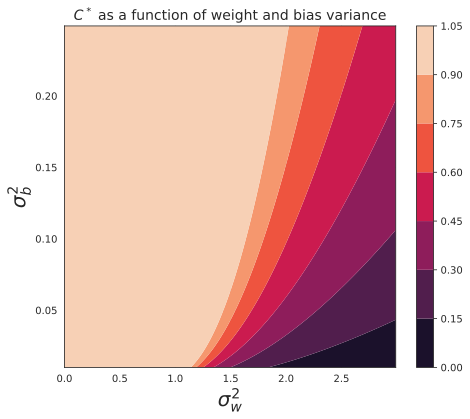

In [0]:
W_var = np.arange(0, 3, 0.01)
b_var = np.arange(0., 0.25, 0.001)

plt.contourf(W_var, b_var, c_star(W_var, b_var))
plt.colorbar()
plt.title('$C^*$ as a function of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1.15, 1))

We can, of course, threshold on $c^*$ to get a cleaner definition of the phase diagram.

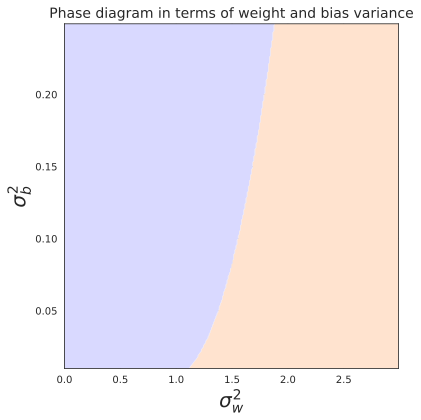

In [0]:
plt.contourf(W_var, b_var, c_star(W_var, b_var) > 0.999, 
             levels=3, 
             colors=[[1.0, 0.89, 0.811], [0.85, 0.85, 1]])
plt.title('Phase diagram in terms of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1, 1))

As described above, the boundary between the two phases should be defined by $\chi_1(\sigma_w^2, \sigma_b^2) = 1$ where $\chi_1$ is given by the derivative of the $\mathcal C$-map.

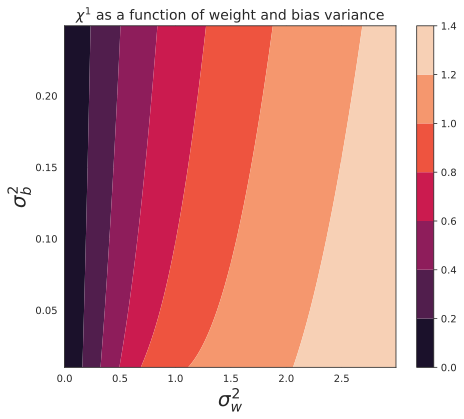

In [0]:
plt.contourf(W_var, b_var, chi_1(W_var, b_var))
plt.colorbar()
plt.title(r'$\chi^1$ as a function of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1.15, 1))

We can see that the boundary where $\chi_1$ crosses 1 corresponds to the phase boundary we observe above.

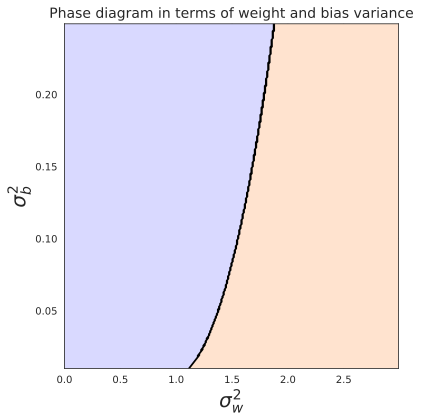

In [0]:
plt.contourf(W_var, b_var, c_star(W_var, b_var) > 0.999, 
             levels=3, 
             colors=[[1.0, 0.89, 0.811], [0.85, 0.85, 1]])
plt.contourf(W_var, b_var, 
             np.abs(chi_1(W_var, b_var) - 1) < 0.003, 
             levels=[0.5, 1], 
             colors=[[0, 0, 0]])

plt.title('Phase diagram in terms of weight and bias variance', fontsize=14)

format_plot('$\\sigma_w^2$', '$\\sigma_b^2$')
finalize_plot((1, 1))